In [1]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap

In [2]:
data_initial = pd.read_csv('data/patient_features_initial.csv')
data_final = pd.read_csv('data/patient_features_final.csv')

data_initial = data_initial.rename({'Stage_Progress' : 'label'}, axis=1)
data_initial['label'] = data_initial['label'].astype('int')

data_final = data_final.rename({'Stage_Progress' : 'label'}, axis=1)
data_final['label'] = data_final['label'].astype('int')

In [3]:
data_initial.head()

,id,race,gender,age,initial_creatinine,initial_eGFR,initial_stage,initial_sbp,initial_dbp,initial_bp_stage,initial_ldl,initial_cholesterol_stage,initial_glucose,initial_diabetes_stage,initial_hgb,cholesterol_drug,diabetes_drug,hbp_lol_drug,hbp_tan_drug,label
0,0,Unknown,Male,70,1.29,55.1,3a,134.11,95.32,Hypertension 1,161.49,High,6.24,Healthy,13.51,0.0,0.0,0.0,0.0,1
1,1,White,Female,71,1.74,28.8,4,157.46,72.49,Hypertension 2,89.57,Optimal,9.96,Diabetes,13.89,0.0,0.0,0.0,0.0,0
2,2,White,Female,57,2.51,19.8,4,132.89,81.13,Hypertension 1,61.62,Optimal,7.24,Diabetes,15.34,0.0,0.0,0.0,0.0,1
3,3,White,Male,74,0.74,103.4,1,147.46,80.09,Hypertension 1,99.71,Optimal,6.43,Healthy,13.74,0.0,0.0,0.0,0.0,0
4,4,White,Female,50,1.34,41.9,3b,128.78,82.23,Hypertension 1,65.73,Optimal,8.76,Diabetes,13.21,1.0,0.0,0.0,0.0,1


In [4]:
data_final.head()

,id,race,gender,age,final_creatinine,final_eGFR,final_stage,final_sbp,final_dbp,final_bp_stage,final_ldl,final_cholesterol_stage,final_glucose,final_diabetes_stage,final_hgb,cholesterol_drug,diabetes_drug,hbp_lol_drug,hbp_tan_drug,label
0,0,Unknown,Male,70,1.23,58.2,3a,147.50,84.29,Hypertension 1,157.90,Borderline High,5.78,Pre-Diabetes,13.13,0.0,1.0,0.0,0.0,1
1,1,White,Female,71,2.20,22.0,4,149.66,90.99,Hypertension 2,73.24,Optimal,9.78,Diabetes,12.85,1.0,0.0,0.0,0.0,0
2,2,White,Female,57,2.20,23.0,4,136.46,91.52,Hypertension 1,87.14,Optimal,7.04,Diabetes,15.19,1.0,0.0,0.0,0.0,1
3,3,White,Male,74,0.90,82.5,2,142.88,67.45,Hypertension 2,101.42,Near/Above Optimal,5.77,Pre-Diabetes,12.66,1.0,0.0,0.0,0.0,0
4,4,White,Female,50,0.93,63.8,2,166.45,104.57,Hypertension 2,72.03,Optimal,11.00,Diabetes,11.63,1.0,1.0,0.0,0.0,1


### Pre-process some features

From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4089662/:

1. Gender seems to be inconclusive
2. African Americans are more prone compared to other ethnicities
3. Elderly are more prone (ages >= 65)

Hence, features will be encoded accordingly

In [5]:
race_map = {i : 1 if i == 'Black'
            else 0 for i in data_initial['race'].unique()}
data_initial['race'] = data_initial['race'].map(race_map)
data_final['race'] = data_final['race'].map(race_map)


gender_map = {i : 1 if i == 'Female'
              else 0 for i in data_initial['gender'].unique()}
data_initial['gender'] = data_initial['gender'].map(gender_map)
data_final['gender'] = data_final['gender'].map(gender_map)


age_map = {i : 1 if i >= 65 
           else 0 for i in data_initial['age'].unique()}
data_initial['age'] = data_initial['age'].map(age_map)
data_final['age'] = data_final['age'].map(age_map)

In [6]:
def drug_map(df, col):
    map_func = {i : 1 if i >= 1 else 0 for i in df[col].unique()}
    df[col] = df[col].map(map_func)
    return df
    
    
for c in ['cholesterol_drug', 'diabetes_drug', 'hbp_lol_drug', 'hbp_tan_drug']:
    data_initial = drug_map(data_initial, c)
    data_final = drug_map(data_final, c)

In [7]:
drop_cols = ['stage', 'bp_stage', 'cholesterol_stage', 'diabetes_stage']
data_initial = data_initial.drop([f'initial_{c}' for c in drop_cols], axis=1)
data_final = data_final.drop([f'final_{c}' for c in drop_cols], axis=1)

In [8]:
data_initial.head()

,id,race,gender,age,initial_creatinine,initial_eGFR,initial_sbp,initial_dbp,initial_ldl,initial_glucose,initial_hgb,cholesterol_drug,diabetes_drug,hbp_lol_drug,hbp_tan_drug,label
0,0,0,0,1,1.29,55.1,134.11,95.32,161.49,6.24,13.51,0,0,0,0,1
1,1,0,1,1,1.74,28.8,157.46,72.49,89.57,9.96,13.89,0,0,0,0,0
2,2,0,1,0,2.51,19.8,132.89,81.13,61.62,7.24,15.34,0,0,0,0,1
3,3,0,0,1,0.74,103.4,147.46,80.09,99.71,6.43,13.74,0,0,0,0,0
4,4,0,1,0,1.34,41.9,128.78,82.23,65.73,8.76,13.21,1,0,0,0,1


In [9]:
data_final.head()

,id,race,gender,age,final_creatinine,final_eGFR,final_sbp,final_dbp,final_ldl,final_glucose,final_hgb,cholesterol_drug,diabetes_drug,hbp_lol_drug,hbp_tan_drug,label
0,0,0,0,1,1.23,58.2,147.50,84.29,157.90,5.78,13.13,0,1,0,0,1
1,1,0,1,1,2.20,22.0,149.66,90.99,73.24,9.78,12.85,1,0,0,0,0
2,2,0,1,0,2.20,23.0,136.46,91.52,87.14,7.04,15.19,1,0,0,0,1
3,3,0,0,1,0.90,82.5,142.88,67.45,101.42,5.77,12.66,1,0,0,0,0
4,4,0,1,0,0.93,63.8,166.45,104.57,72.03,11.00,11.63,1,1,0,0,1


### Calculating changes
Calculate differences between first entry in database and last

In [10]:
val1 = data_initial.iloc[:, 4:11].values
val2 = data_final.iloc[:, 4:11].values

vals = val1 - val2

data = data_initial.copy()
data.iloc[:, 4:11] = vals

data = data.iloc[:, :11]
data['label'] = data_initial['label']
data.columns = ['id', 'race', 'gender', 'age', 'creatinine_diff', 
                'eGFR_diff', 'sbp_diff', 'dbp_diff', 'ldl_diff', 
                'glucose_diff', 'hgb_diff', 'label']
data.head()

,id,race,gender,age,creatinine_diff,eGFR_diff,sbp_diff,dbp_diff,ldl_diff,glucose_diff,hgb_diff,label
0,0,0,0,1,0.06,-3.1,-13.39,11.03,3.59,0.46,0.38,1
1,1,0,1,1,-0.46,6.8,7.80,-18.50,16.33,0.18,1.04,0
2,2,0,1,0,0.31,-3.2,-3.57,-10.39,-25.52,0.20,0.15,1
3,3,0,0,1,-0.16,20.9,4.58,12.64,-1.71,0.66,1.08,0
4,4,0,1,0,0.41,-21.9,-37.67,-22.34,-6.30,-2.24,1.58,1


In [11]:
seed = 111
np.random.seed(seed)

train, test = train_test_split(data, test_size=0.2, random_state=seed)
X_train, y_train = train.drop(['id', 'label'], axis=1), train['label']
X_test, y_test = test.drop(['id', 'label'], axis=1), test['label']

In [12]:
# Check no leakage
print(train['id'].nunique())
print(test['id'].nunique())
print(len(set(train['id'].values.tolist() + test['id'].values.tolist())))

240
60
300


### Modelling for initial data

In [13]:
params = {'C' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
          'max_iter' : [250, 500, 1000]}

logreg = LogisticRegression(random_state=seed, verbose=0)

logreg_cv = GridSearchCV(logreg, params, 
                         scoring='roc_auc', cv=5, verbose=0)

logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=111),
             param_grid={'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
                         'max_iter': [250, 500, 1000]},
             scoring='roc_auc')

In [14]:
print(logreg_cv.best_params_)
print(logreg_cv.best_score_)

logreg = LogisticRegression(C=0.5, max_iter=250, 
                            random_state=seed, verbose=0)

logreg.fit(X_train, y_train)

{'C': 0.5, 'max_iter': 250}
0.8682804608585858


LogisticRegression(C=0.5, max_iter=250, random_state=111)

In [15]:
logreg.coef_

array([[-0.53294448, -0.83161609, -0.34467248, -0.17316842, -0.01014684,
        -0.05671691, -0.02501452, -0.09641628, -0.45738708,  0.14355403]])

In [16]:
def calc_metrics(true, pred):    
    raw_data = pd.DataFrame({'true' : true, 'pred' : pred})
    n_row = raw_data.shape[0]
    print(f'No. of observations: {n_row}')
    print(f"No. of positive obs: {raw_data[raw_data['true'] == 1].shape[0]},\
    No. of negative obs: {raw_data[raw_data['true'] == 0].shape[0]}")
    
    tp = raw_data[(raw_data['true'] == 1) & (raw_data['pred'] == 1)].shape[0]
    tn = raw_data[(raw_data['true'] == 0) & (raw_data['pred'] == 0)].shape[0]
    fp = raw_data[(raw_data['true'] == 0) & (raw_data['pred'] == 1)].shape[0]
    fn = raw_data[(raw_data['true'] == 1) & (raw_data['pred'] == 0)].shape[0]
    
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    
    print(f'\nAccuracy: {round((tp + tn) / n_row, 4)}')
    print(f'TPR: {round(tp / (tp + fn), 4)}, TNR: {round(tn / (tn + fp), 4)}')
    print(f'FPR: {round(fp / (fp + tn), 4)}, FNR: {round(fn / (fn + tp), 4)}')
    
    print(f'\nPrecision: {round(precision_score(true, pred), 4)}, Recall: {round(recall_score(true, pred), 4)}')
    print(f'AUC score: {round(roc_auc_score(true, pred), 4)}, f1 score: {round(f1_score(true, pred), 4)}')
    
    
    #Print Confusion Matrix
    plt.figure()
    cm = confusion_matrix(true, pred)
    labels = ['Non-progress', 'Progress']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='d', cmap="Blues", vmin=0.2,
                cbar=False);
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.show()

No. of observations: 60
No. of positive obs: 21,    No. of negative obs: 39
TP: 18, TN: 31, FP: 8, FN: 3

Accuracy: 0.8167
TPR: 0.8571, TNR: 0.7949
FPR: 0.2051, FNR: 0.1429

Precision: 0.6923, Recall: 0.8571
AUC score: 0.826, f1 score: 0.766


<Figure size 432x288 with 0 Axes>

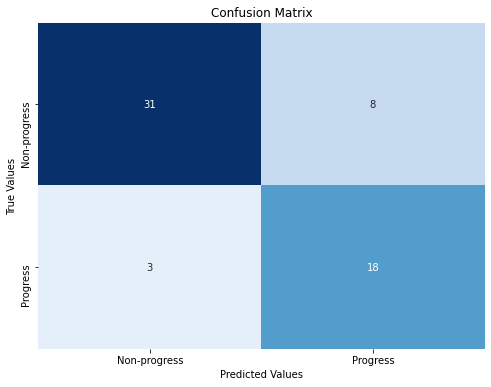

In [17]:
threshold = 0.4
y_pred = logreg.predict_proba(X_test)[:, 1]
y_pred = [1 if p >= threshold else 0 for p in y_pred]

calc_metrics(y_test, y_pred)

### SHAP values

In [22]:
import shap

explainer = shap.LinearExplainer(logreg, X_train)
shap_values = explainer.shap_values(X_test)

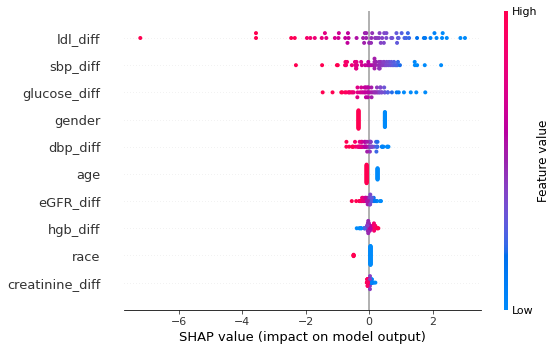

In [23]:
shap.summary_plot(shap_values, X_test)